In [2]:
import os
import numpy as np
import cv2
import random
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Read names of the images

In [3]:
path = "dataset"
with_mask = "with_mask" #0
without_mask = "without_mask" #+1
img_size = 224

names_images_with_mask = np.array(os.listdir(os.path.join(path,with_mask)))
names_images_without_mask = np.array(os.listdir(os.path.join(path,without_mask)))

# Read images

In [4]:
def read_images(general_path,names_images,index_class):
    images_classes = []
    for name in names_images:
        try:
            img = cv2.resize(cv2.imread(general_path + "\\" + name ),(img_size,img_size))
            images_classes.append([img,index_class])
        except Exception as e:
            pass
    return images_classes

In [5]:
images_with_mask = read_images(os.path.join(path,with_mask),names_images_with_mask,0)
images_without_mask = read_images(os.path.join(path,without_mask),names_images_without_mask,1)

# Create training data

In [6]:
def create_training_data(images_with_mask,images_without_mask):
    return images_with_mask + images_without_mask

In [7]:
training_data = create_training_data(images_with_mask,images_without_mask)
random.shuffle(training_data)

# Design Matrix and Vector of Labels

In [8]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,img_size,img_size,3)
y = np.array(y)
X = X/255.0

# Split into Training, Validation and Test Set

In [9]:
training_size = round(0.6 * X.shape[0])
validation_size = round(0.2 * X.shape[0])
test_size = X.shape[0] - training_size - validation_size

X_train = X[0:training_size,:,:,:]
X_validation = X[training_size : training_size + validation_size,:,:,:]
X_test = X[training_size + validation_size: X.shape[0],:,:,:]

y_train = y[0:training_size]
y_validation = y[training_size : training_size + validation_size]
y_test = y[training_size + validation_size: len(y)]

# Save and Load Training, Validation and Test Data

In [10]:
pickle_out = open("models_new\X_train.pickle","wb")
pickle.dump(X_train,pickle_out,protocol=4) #more than 4 gb
pickle_out = open("models_new\X_validation.pickle","wb")
pickle.dump(X_validation,pickle_out,protocol=4) #more than 4 gb
pickle_out = open("models_new\X_test.pickle","wb")
pickle.dump(X_test,pickle_out,protocol=4) #more than 4 gb
pickle_out.close()

pickle_out = open("models_new\y_train.pickle","wb")
pickle.dump(y_train,pickle_out)
pickle_out = open("models_new\y_validation.pickle","wb")
pickle.dump(y_validation,pickle_out)
pickle_out = open("models_new\y_test.pickle","wb")
pickle.dump(y_test,pickle_out)
pickle_out.close()

In [ ]:
pickle_in =  open("models_new\X_train.pickle","rb")
X_train = pickle.load(pickle_in)
pickle_in =  open("models_new\X_validation.pickle","rb")
X_validation = pickle.load(pickle_in)
pickle_in =  open("models_new\X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in =  open("models_new\y_train.pickle","rb")
y_train = pickle.load(pickle_in)
pickle_in =  open("models_new\y_validation.pickle","rb")
y_validation = pickle.load(pickle_in)
pickle_in =  open("models_new\y_test.pickle","rb")
y_test = pickle.load(pickle_in)

# Preparation of the Neural Network

In [11]:
model = tf.keras.applications.ResNet50(weights="imagenet")
base_input = model.layers[0].input
base_output = model.layers[-3].output
flat_layer = layers.Flatten()(base_output)
another_layer = layers.Dense(1)(flat_layer)
final_layer = layers.Activation('sigmoid')(another_layer)
final_model = keras.Model(inputs=base_input, outputs = final_layer)

i=0
for layer in final_model.layers:
    if(i == (len(final_model.layers) -2)):
        break
    else:
        i = i + 1
        layer.trainable = False

final_model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),metrics =["accuracy"])

callback = tf.keras.callbacks.ModelCheckpoint('best_val_loss_model.h5', monitor='val_loss', mode='min',verbose=1)

# Train of the Neural Network

In [12]:
history = final_model.fit(X_train,y_train,epochs = 15, validation_data = (X_validation,y_validation),batch_size = 64,callbacks=[callback])

Epoch 1/15
37/37 [==============================] - ETA: 0s - loss: 3.4742 - accuracy: 0.7222
Epoch 1: saving model to best_val_loss_model.h5
37/37 [==============================] - 22s 433ms/step - loss: 3.4742 - accuracy: 0.7222 - val_loss: 1.6541 - val_accuracy: 0.5754
Epoch 2/15
37/37 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.7554
Epoch 2: saving model to best_val_loss_model.h5
37/37 [==============================] - 14s 375ms/step - loss: 1.0600 - accuracy: 0.7554 - val_loss: 0.7402 - val_accuracy: 0.8338
Epoch 3/15
37/37 [==============================] - ETA: 0s - loss: 0.4887 - accuracy: 0.8718
Epoch 3: saving model to best_val_loss_model.h5
37/37 [==============================] - 14s 373ms/step - loss: 0.4887 - accuracy: 0.8718 - val_loss: 0.4625 - val_accuracy: 0.9054
Epoch 4/15
37/37 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9497
Epoch 4: saving model to best_val_loss_model.h5
37/37 [=============================

# Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


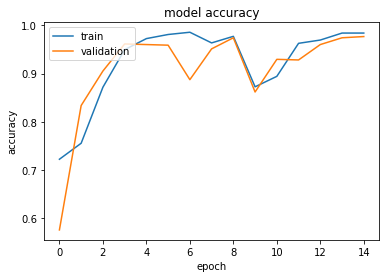

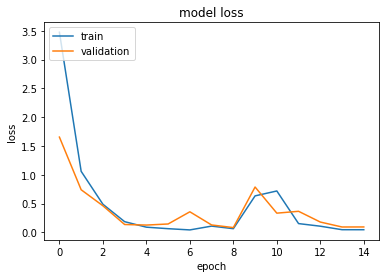

In [13]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Load Best Models

In [14]:
best_model = tf.keras.models.load_model("best_val_loss_model.h5")

# Performances on the Test Set

In [16]:
def transform_to_labels(predictions):
    y_predicted = []
    for prediction in predictions:
        if(prediction >= 0.5):
            y_predicted.append(1)
        else:
            y_predicted.append(0)
    return np.array(y_predicted)

In [17]:
predicted_labels = transform_to_labels(best_model.predict(X_test[:,:,:,:]))

In [28]:
print("Accuracy on the Test Set : " , ((len(y_test) - np.count_nonzero((predicted_labels + y_test) == 1)) / len(y_test)))

Accuracy on the Test Set :  0.9859514687100894
